<a href="https://colab.research.google.com/github/shivupoojar/Outlier-Detection-for-Puhatu-Monitoring-/blob/main/puhatu_c1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [207]:
!pwd
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/Outlier-Detection-for-Puhatu-Monitoring-
%cd data/
!pip install pyod


/content/drive/My Drive/Colab Notebooks/Outlier-Detection-for-Puhatu-Monitoring-/data
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Outlier-Detection-for-Puhatu-Monitoring-
/content/drive/My Drive/Colab Notebooks/Outlier-Detection-for-Puhatu-Monitoring-/data


In [208]:
import pandas as pd
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import io


Data preparation

In [209]:
df=pd.read_csv('puhatu_c1.csv',parse_dates=['time'],usecols=['time','dev_id','batt','rssi','snr','air_Pressure_mH2o','air_Temp_float','dist','wat_Pressure_mH2o','wat_Temp_float'])
df = df.apply(pd.to_numeric, errors='coerce')
df['time'] = df['time'].astype('datetime64[ns]')
df = df.drop(['dev_id'], axis=1)
df.set_index('time',inplace=True)

columns = df.columns
df['month']= df.index.month
df['year']= df.index.year
#df=df.dropna()
df = df.loc[df['year'] == 2021]
print(df.duplicated)

<bound method DataFrame.duplicated of                      air_Pressure_mH2o  air_Temp_float  ...  month  year
time                                                    ...             
2021-01-01 00:13:20          10.301974        0.389994  ...      1  2021
2021-01-01 05:46:40          10.305521        0.256712  ...      1  2021
2021-01-01 08:33:20          10.311554        0.929001  ...      1  2021
2021-01-01 14:06:40          10.305520        0.638091  ...      1  2021
2021-01-01 16:53:20          10.293324       -0.011487  ...      1  2021
...                                ...             ...  ...    ...   ...
2021-06-28 14:20:00          -1.000000        0.000000  ...      6  2021
2021-06-28 22:40:00          -1.000000        0.000000  ...      6  2021
2021-06-29 15:20:00          -1.000000        0.000000  ...      6  2021
2021-07-01 20:06:40          -1.000000        0.000000  ...      7  2021
2021-07-04 12:00:00          -1.000000        0.000000  ...      7  2021

[888 rows x 

In [210]:
# Function that calculates the percentage of missing values
def calc_percent_NAs(df):
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df), columns=['percent']) 
    idx = nans['percent'] > 0
    return nans[idx]
# Let's use above function to look at top ten columns with NaNs
calc_percent_NAs(df)

,percent


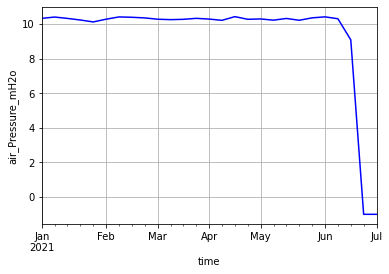

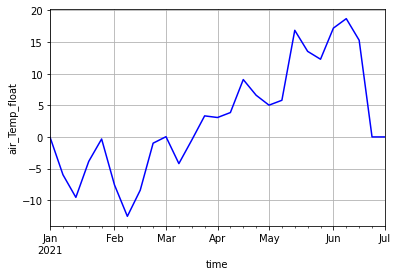

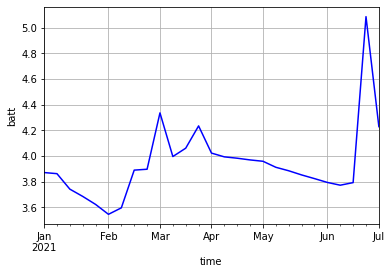

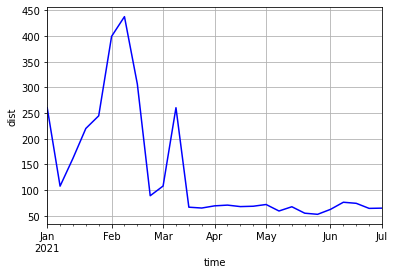

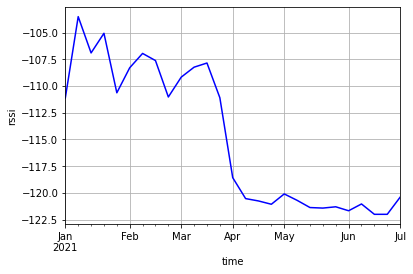

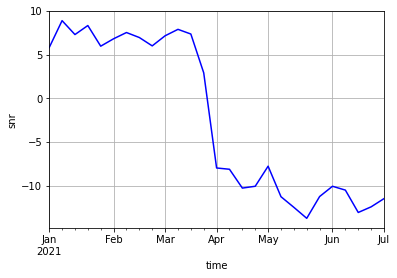

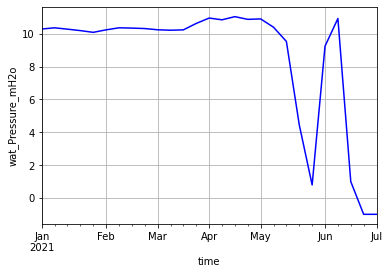

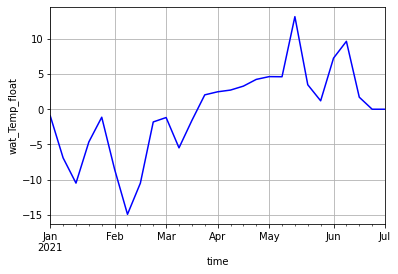

In [211]:
df = df.resample('W').mean()
for col in columns:
    df[col].plot(color='blue', grid=True)
    plt.ylabel(col)
    plt.show()
    


Checking for data stationary over the time using ADFuller Test

In [212]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
for col in columns:
    print(col)
    df1= df[col]
    
    df1 = df1.dropna()
    
    result = adfuller(df1)
    print("-----------ADF Test for "+col+"START ------------")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print("-----------ADF Test for "+col+"END ------------")

        
 #   decompose  = seasonal_decompose(df[col].resample('D').sum(),freq=12)
 #   fig = plt.figure()
#    print(col)
 #   fig = decompose.plot()
 #   fig.set_size_inches(12,8)

air_Pressure_mH2o
-----------ADF Test for air_Pressure_mH2oSTART ------------
ADF Statistic: -2.226407
p-value: 0.196801
Critical Values:
	1%: -3.738
	5%: -2.992
	10%: -2.636
-----------ADF Test for air_Pressure_mH2oEND ------------
air_Temp_float
-----------ADF Test for air_Temp_floatSTART ------------
ADF Statistic: -1.584656
p-value: 0.491297
Critical Values:
	1%: -3.711
	5%: -2.981
	10%: -2.630
-----------ADF Test for air_Temp_floatEND ------------
batt
-----------ADF Test for battSTART ------------
ADF Statistic: -3.336055
p-value: 0.013342
Critical Values:
	1%: -3.711
	5%: -2.981
	10%: -2.630
-----------ADF Test for battEND ------------
dist
-----------ADF Test for distSTART ------------
ADF Statistic: -7.478381
p-value: 0.000000
Critical Values:
	1%: -3.833
	5%: -3.031
	10%: -2.656
-----------ADF Test for distEND ------------
rssi
-----------ADF Test for rssiSTART ------------
ADF Statistic: -2.869526
p-value: 0.049008
Critical Values:
	1%: -3.889
	5%: -3.054
	10%: -2.667
------

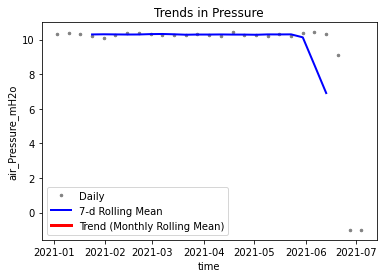

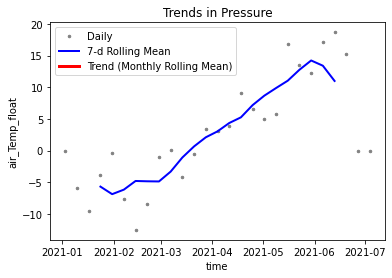

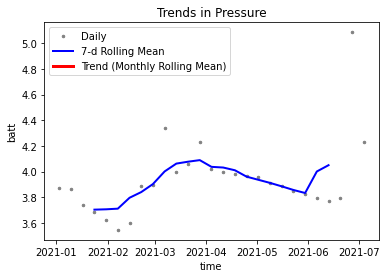

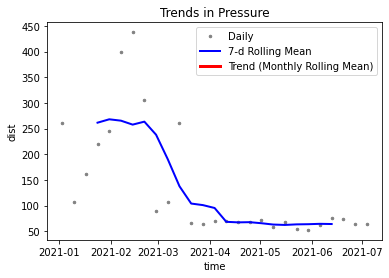

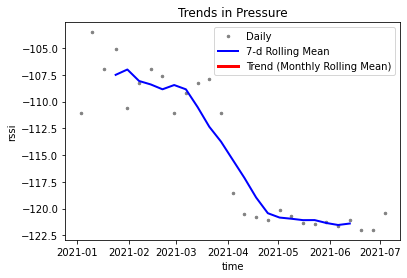

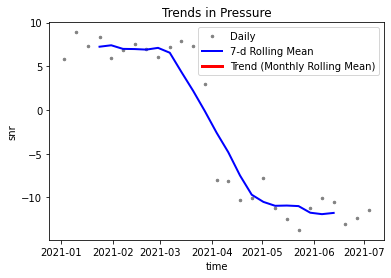

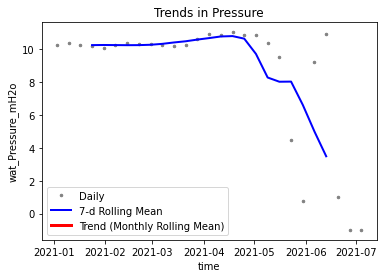

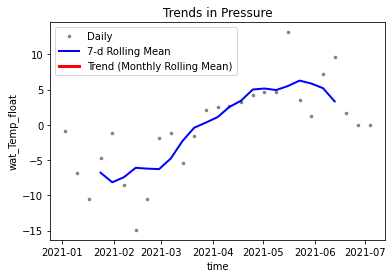

In [213]:
import matplotlib.dates as mdates
df_roll7 = df.rolling(window=7, center=True, min_periods=7).mean()
df_roll30 = df.rolling(window=30, center=True, min_periods=30).mean()
for col in columns:
  fig, ax = plt.subplots()
  ax.plot(df[col], marker='.', markersize=5, color='0.5',  linestyle='None', label='Daily')
  ax.plot(df_roll7[col], linewidth=2, color='blue',label='7-d Rolling Mean')
  ax.plot(df_roll30[col], color='red', linewidth=3, label='Trend (Monthly Rolling Mean)')
# Set x-ticks to yearly interval and add legend and labels
  ax.xaxis.set_major_locator(mdates.MonthLocator())
  ax.legend()
  ax.set_xlabel('time')
  ax.set_ylabel(col)
  ax.set_title('Trends in Pressure');

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
import plotly.express as px


import matplotlib.font_manager
from pyod.models.cblof import CBLOF
# Import models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
#from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from sklearn.cluster import DBSCAN
from pyod.models.ocsvm import OCSVM
# reading the big mart sales training data
from sklearn.preprocessing import MinMaxScaler

from joblib import dump, load

from sklearn.metrics import classification_report,accuracy_score

In [215]:
# min max scalling
scaler = MinMaxScaler(feature_range=(0, 1))
df[['wat_Pressure_mH2o','air_Pressure_mH2o','air_Temp_float','wat_Temp_float','dist']] = scaler.fit_transform(df[['wat_Pressure_mH2o','air_Pressure_mH2o','air_Temp_float','wat_Temp_float','dist']])
#df[['wat_Pressure_mH2o','air_Pressure_mH2o','air_Temp_float','wat_Temp_float','dist']] = scaler.fit_transform(df[['wat_Pressure_mH2o','air_Pressure_mH2o','air_Temp_float','wat_Temp_float','dist']])
X = df[['wat_Pressure_mH2o','air_Pressure_mH2o','air_Temp_float','wat_Temp_float','dist']]

In [216]:
# declare the outlier mechanisms
import warnings
warnings.filterwarnings('ignore')

random_state = np.random.RandomState(42)
outliers_fraction = 0.15
# Define seven outlier detection tools to be compared
classifiers = {
     #    'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
     #    'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        #'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
     #    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(n_estimators=35,contamination=outliers_fraction,random_state=random_state),
     #    'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
      #  'Average KNN': KNN(method='mean',contamination=outliers_fraction),
        'One Class SVM': OCSVM(contamination=outliers_fraction)
          
}

In [217]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.model_selection import train_test_split
from pyod.utils.data import evaluate_print


xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))
import seaborn as sns
for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    xtrain, xtest = np.array_split(X,2)
  #  print(xtrain.shape)
 #   print(xtest.shape)
 #   xtrain, xtest, labels_train, labels_test = train_test_split(df, df['batt'], test_size=0.50, random_state=42)  
    clf.fit(xtrain)
   # xtest1=xtest
    
   # prediction of a datapoint category outlier or inlier
    y_train = clf.predict(xtrain)
    y_test = clf.predict(xtest)
    xtrain_score = clf.decision_function(xtrain)
    xtest_score = clf.decision_function(xtest)
  
    

    
    n_inliers = len(y_test) - np.count_nonzero(y_test)
    n_outliers = np.count_nonzero(y_test == 1) 

#     dfx = xtest1
    
#     dfx['outlier'] = y_pred.tolist()

    
# evaluate and print the results
    print("\nOn Training Data:")
    evaluate_print(clf_name,y_train, xtrain_score)
    print("\nOn Test Data:")
    evaluate_print(clf_name, y_test, xtest_score)
   
    print('################################## START ######################')
    print('Accuracy Score: ', accuracy_score(y_train, y_test),clf_name)
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
    
    print(confusion_matrix(y_true, y_pred))

    print(classification_report(y_true, y_pred))

    # evaluate and print the results
    print("\nOn Training Data:")
    evaluate_print(clf_name, y_true, prediction_score_xtrain)
    print("\nOn Test Data:")
    evaluate_print(clf_name, y_pred, prediction_score_xtest)
 #   print(xtrain)
 #   print(xtest) 
    xtrain_wat_temp['dist'] = xtrain['dist']
    xtest_wat_temp['dist'] = xtest['dist']
    print('################################## END ######################')
    print(xtrain.shape,y_train.shape,xtest.shape,y_test.shape)



On Training Data:
Isolation Forest ROC:1.0, precision @ rank n:1.0

On Test Data:
Isolation Forest ROC:1.0, precision @ rank n:1.0
################################## START ######################


ValueError: ignored